In [3]:
import pandas as pd

# Загрузить первый файл
file_path_1 = '/Users/elizaveta/Downloads/survival_GBM_survival.txt'
data_1 = pd.read_csv(file_path_1, sep='\t')
print(data_1.describe())

# Извлечь колонку 'sample' из первого файла
samples_1 = data_1['sample']

# Загрузить второй файл (dataset.csv)
file_path_2 = '/Users/elizaveta/Downloads/TCGA_GBM_sampleMap_HT_HG-U133A.csv'
data_2 = pd.read_csv(file_path_2)

# Фильтрация данных по интересующим генам
genes_of_interest = ['EGFR', 'PTEN', 'TP53', 'MDM2', 'CDK4']
data_2 = data_2[data_2['sample'].isin(genes_of_interest)]

# Извлечь первую строку из второго файла (предполагается, что первая строка содержит sample)
samples_2 = data_2.columns

# Найти общие samples
common_samples = set(samples_1).intersection(set(samples_2))

# Вывести количество общих samples
print(f'Количество общих samples: {len(common_samples)}')

# Вывести общие samples
print(f'Общие samples: {common_samples}')

# Фильтрация данных по общим samples
filtered_data_1 = data_1[data_1['sample'].isin(common_samples)]
filtered_data_2 = data_2[['sample'] + list(common_samples)]

print("Filtered Survival Data:")
print(filtered_data_1.head())

print("Filtered Expression Data:")
print(filtered_data_2.head())

# Транспонирование данных экспрессии генов
transposed_filtered_data_2 = filtered_data_2.set_index('sample').transpose()

num_rows_transposed_filtered_data_2 = transposed_filtered_data_2.shape[0]
print(f'Количество строк в transposed_filtered_data_2: {num_rows_transposed_filtered_data_2}')


print("Transposed Filtered Expression Data:")
print(transposed_filtered_data_2.head())

               OS      OS.time         DSS     DSS.time       DFI  \
count  602.000000   602.000000  561.000000   602.000000  3.000000   
mean     0.823920   500.642857    0.802139   500.642857  0.666667   
std      0.381205   536.364905    0.398742   536.364905  0.577350   
min      0.000000     0.000000    0.000000     0.000000  0.000000   
25%      1.000000   167.500000    1.000000   167.500000  0.500000   
50%      1.000000   370.000000    1.000000   370.000000  1.000000   
75%      1.000000   609.250000    1.000000   609.250000  1.000000   
max      1.000000  3881.000000    1.000000  3881.000000  1.000000   

          DFI.time         PFI     PFI.time  Redaction  
count     3.000000  602.000000   602.000000        0.0  
mean    906.333333    0.850498   305.551495        NaN  
std     597.637292    0.356879   401.132687        NaN  
min     369.000000    0.000000     0.000000        NaN  
25%     584.500000    1.000000    95.000000        NaN  
50%     800.000000    1.000000   183

In [4]:
# Сброс индекса в данных выживаемости для слияния
filtered_data_1 = filtered_data_1.set_index('sample')

# Объединение данных
combined_data = pd.concat([filtered_data_1, transposed_filtered_data_2], axis=1)

print("Combined Data:")
print(combined_data.head())

Combined Data:
                     _PATIENT  OS  OS.time  DSS  DSS.time  DFI  DFI.time  PFI  \
TCGA-02-0001-01  TCGA-02-0001   1      358  1.0       358  NaN       NaN    1   
TCGA-02-0003-01  TCGA-02-0003   1      144  1.0       144  NaN       NaN    1   
TCGA-02-0007-01  TCGA-02-0007   1      705  1.0       705  NaN       NaN    1   
TCGA-02-0009-01  TCGA-02-0009   1      322  1.0       322  NaN       NaN    1   
TCGA-02-0010-01  TCGA-02-0010   1     1077  1.0      1077  NaN       NaN    1   

                 PFI.time  Redaction      MDM2       CDK4      PTEN      TP53  \
TCGA-02-0001-01       137        NaN  4.578465   8.281423  5.332169  5.684728   
TCGA-02-0003-01        40        NaN  4.555150   9.977800  5.643208  5.712182   
TCGA-02-0007-01       518        NaN  4.487640  10.043621  6.245905  4.621839   
TCGA-02-0009-01       264        NaN  4.204468  10.084010  6.385176  6.767385   
TCGA-02-0010-01       351        NaN  4.576823   9.887869  6.825424  4.541908   

           

In [5]:
columns_to_keep = ['OS', 'OS.time'] + genes_of_interest
combined_data_filtered = combined_data[columns_to_keep]

# Вывод первых строк объединенных данных
print("Filtered Combined Data:")
print(combined_data_filtered.head())

Filtered Combined Data:
                 OS  OS.time      EGFR      PTEN      TP53      MDM2  \
TCGA-02-0001-01   1      358  7.467593  5.332169  5.684728  4.578465   
TCGA-02-0003-01   1      144  5.570973  5.643208  5.712182  4.555150   
TCGA-02-0007-01   1      705  5.603326  6.245905  4.621839  4.487640   
TCGA-02-0009-01   1      322  5.464747  6.385176  6.767385  4.204468   
TCGA-02-0010-01   1     1077  5.085799  6.825424  4.541908  4.576823   

                      CDK4  
TCGA-02-0001-01   8.281423  
TCGA-02-0003-01   9.977800  
TCGA-02-0007-01  10.043621  
TCGA-02-0009-01  10.084010  
TCGA-02-0010-01   9.887869  


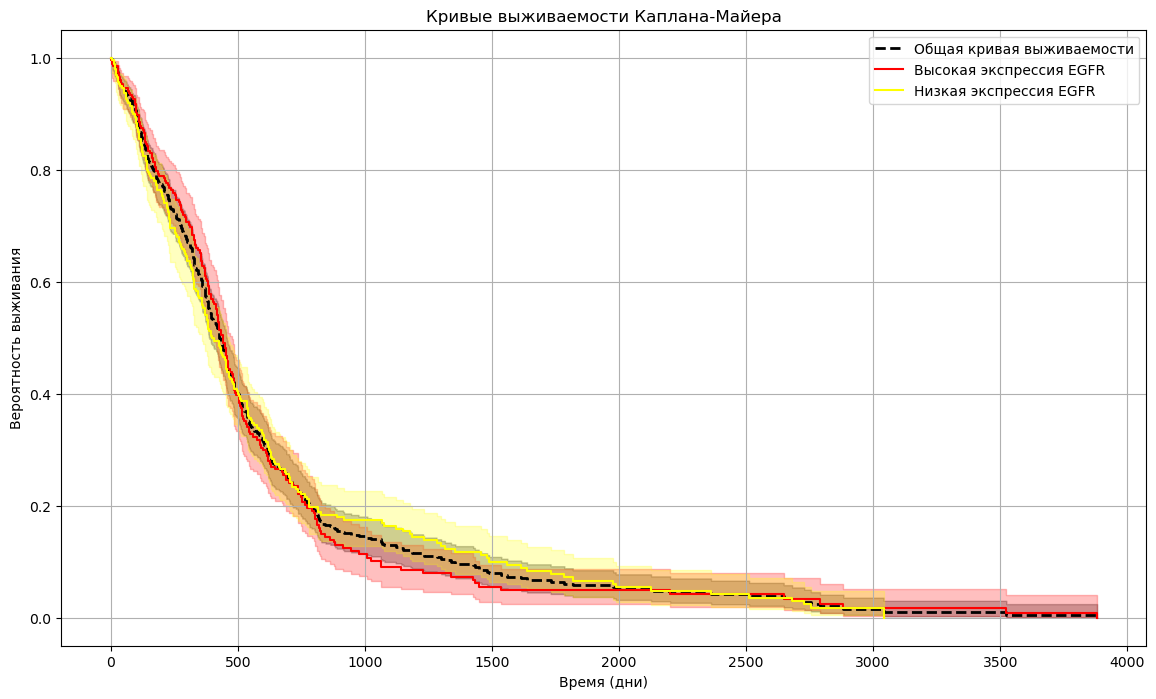

In [6]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter


# Инициализация объекта KaplanMeierFitter
kmf = KaplanMeierFitter()

# Подгонка модели для общей кривой выживаемости
T = combined_data_filtered['OS.time']  # время выживания
E = combined_data_filtered['OS']       # событие (1 - событие наступило, 0 - цензура)

kmf.fit(T, event_observed=E, label='Общая кривая выживаемости')

# Построение общей кривой выживаемости
plt.figure(figsize=(14, 8))
ax = kmf.plot_survival_function(color='black', linestyle='--', linewidth=2)

# Построение кривых выживаемости для групп с высокой и низкой экспрессией EGFR
gene = 'EGFR'
high_expression = combined_data_filtered[combined_data_filtered[gene] > combined_data_filtered[gene].median()]
low_expression = combined_data_filtered[combined_data_filtered[gene] <= combined_data_filtered[gene].median()]

kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

T_high = high_expression['OS.time']
E_high = high_expression['OS']

T_low = low_expression['OS.time']
E_low = low_expression['OS']

kmf_high.fit(T_high, event_observed=E_high, label=f'Высокая экспрессия {gene}')
kmf_low.fit(T_low, event_observed=E_low, label=f'Низкая экспрессия {gene}')

kmf_high.plot_survival_function(ax=ax, color='red', linestyle='-', linewidth=1.5)
kmf_low.plot_survival_function(ax=ax, color='yellow', linestyle='-', linewidth=1.5)

# Настройка графика
plt.title('Кривые выживаемости Каплана-Майера')
plt.xlabel('Время (дни)')
plt.ylabel('Вероятность выживания')
plt.grid(True)
plt.legend()
plt.show()

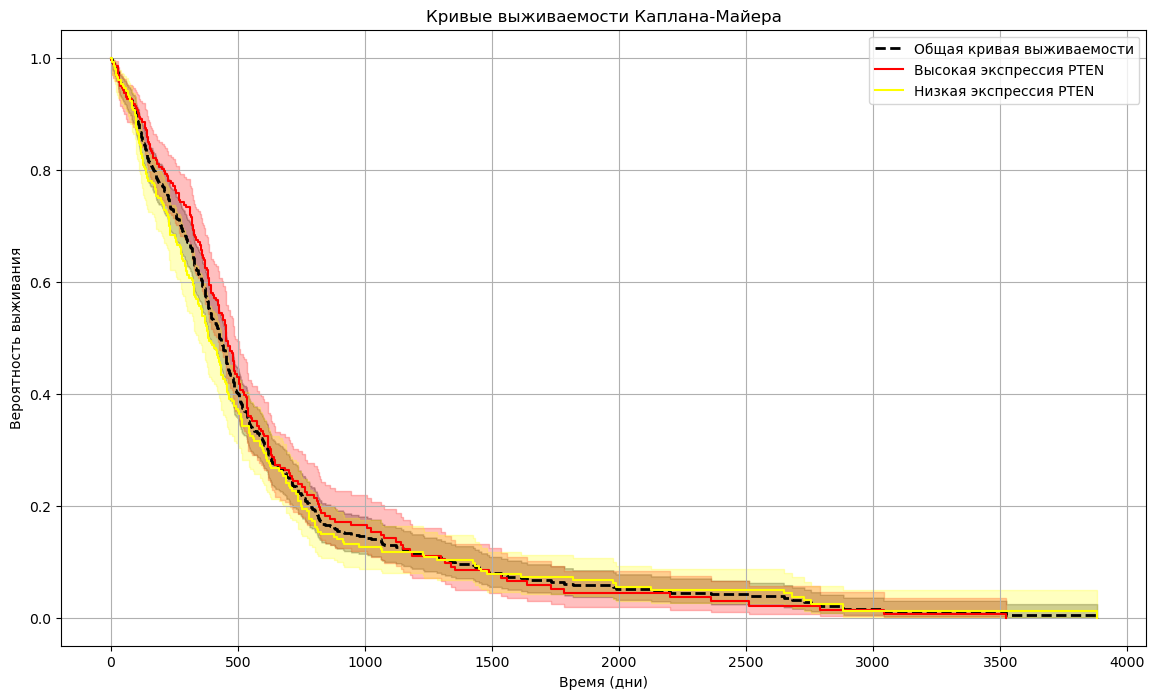

In [7]:
# Инициализация объекта KaplanMeierFitter
kmf = KaplanMeierFitter()

# Подгонка модели для общей кривой выживаемости
T = combined_data_filtered['OS.time']  # время выживания
E = combined_data_filtered['OS']       # событие (1 - событие наступило, 0 - цензура)

kmf.fit(T, event_observed=E, label='Общая кривая выживаемости')

# Построение общей кривой выживаемости
plt.figure(figsize=(14, 8))
ax = kmf.plot_survival_function(color='black', linestyle='--', linewidth=2)

# Построение кривых выживаемости для групп с высокой и низкой экспрессией PTEN
gene = 'PTEN'
high_expression = combined_data_filtered[combined_data_filtered[gene] > combined_data_filtered[gene].median()]
low_expression = combined_data_filtered[combined_data_filtered[gene] <= combined_data_filtered[gene].median()]

kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

T_high = high_expression['OS.time']
E_high = high_expression['OS']

T_low = low_expression['OS.time']
E_low = low_expression['OS']

kmf_high.fit(T_high, event_observed=E_high, label=f'Высокая экспрессия {gene}')
kmf_low.fit(T_low, event_observed=E_low, label=f'Низкая экспрессия {gene}')

kmf_high.plot_survival_function(ax=ax, color='red', linestyle='-', linewidth=1.5)
kmf_low.plot_survival_function(ax=ax, color='yellow', linestyle='-', linewidth=1.5)

# Настройка графика
plt.title('Кривые выживаемости Каплана-Майера')
plt.xlabel('Время (дни)')
plt.ylabel('Вероятность выживания')
plt.grid(True)
plt.legend()
plt.show()

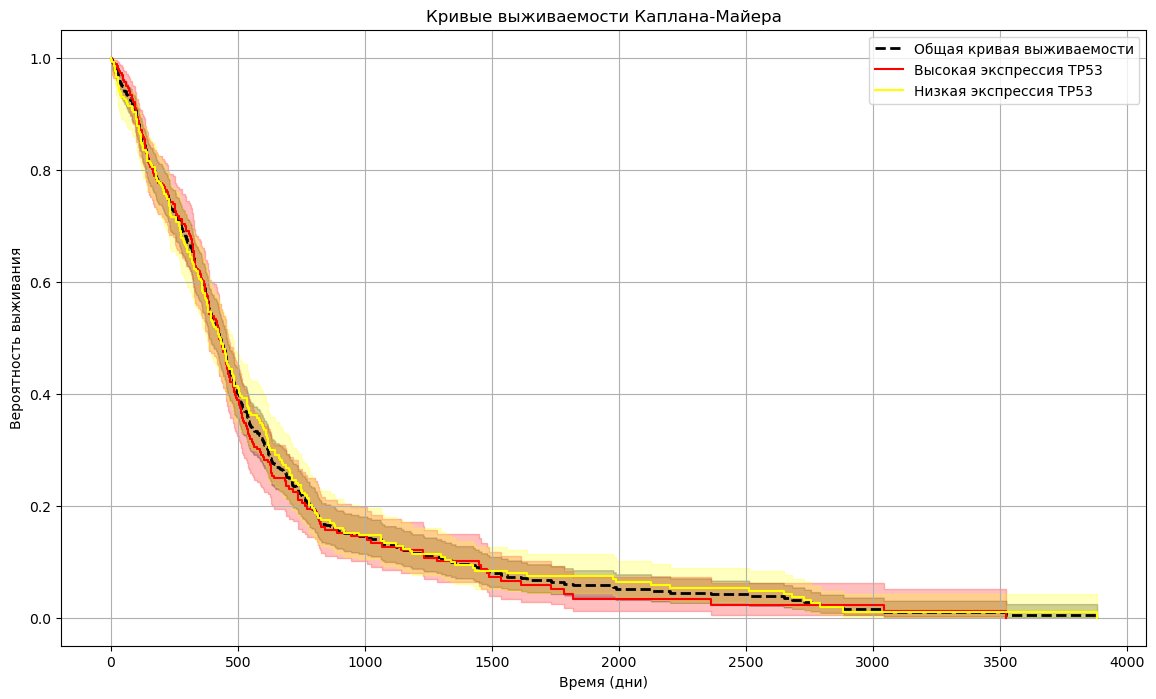

In [8]:
# Инициализация объекта KaplanMeierFitter
kmf = KaplanMeierFitter()

# Подгонка модели для общей кривой выживаемости
T = combined_data_filtered['OS.time']  # время выживания
E = combined_data_filtered['OS']       # событие (1 - событие наступило, 0 - цензура)

kmf.fit(T, event_observed=E, label='Общая кривая выживаемости')

# Построение общей кривой выживаемости
plt.figure(figsize=(14, 8))
ax = kmf.plot_survival_function(color='black', linestyle='--', linewidth=2)

# Построение кривых выживаемости для групп с высокой и низкой экспрессией TP53
gene = 'TP53'
high_expression = combined_data_filtered[combined_data_filtered[gene] > combined_data_filtered[gene].median()]
low_expression = combined_data_filtered[combined_data_filtered[gene] <= combined_data_filtered[gene].median()]

kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

T_high = high_expression['OS.time']
E_high = high_expression['OS']

T_low = low_expression['OS.time']
E_low = low_expression['OS']

kmf_high.fit(T_high, event_observed=E_high, label=f'Высокая экспрессия {gene}')
kmf_low.fit(T_low, event_observed=E_low, label=f'Низкая экспрессия {gene}')

kmf_high.plot_survival_function(ax=ax, color='red', linestyle='-', linewidth=1.5)
kmf_low.plot_survival_function(ax=ax, color='yellow', linestyle='-', linewidth=1.5)

# Настройка графика
plt.title('Кривые выживаемости Каплана-Майера')
plt.xlabel('Время (дни)')
plt.ylabel('Вероятность выживания')
plt.grid(True)
plt.legend()
plt.show()

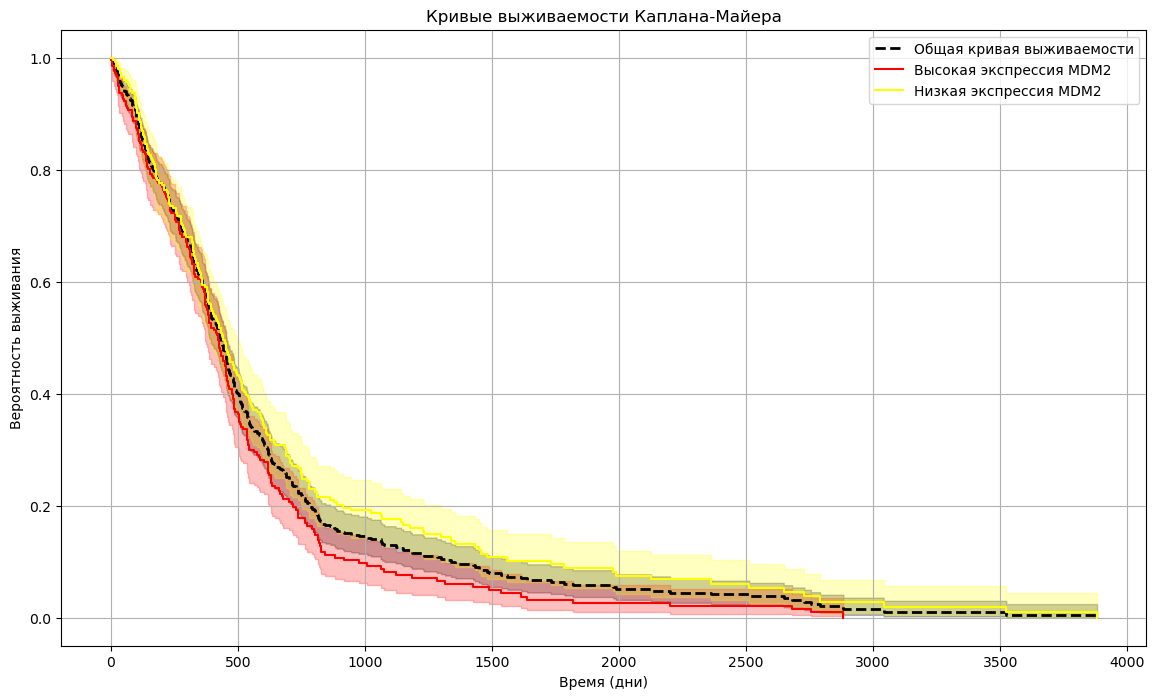

In [9]:
# Инициализация объекта KaplanMeierFitter
kmf = KaplanMeierFitter()

# Подгонка модели для общей кривой выживаемости
T = combined_data_filtered['OS.time']  # время выживания
E = combined_data_filtered['OS']       # событие (1 - событие наступило, 0 - цензура)

kmf.fit(T, event_observed=E, label='Общая кривая выживаемости')

# Построение общей кривой выживаемости
plt.figure(figsize=(14, 8))
ax = kmf.plot_survival_function(color='black', linestyle='--', linewidth=2)

# Построение кривых выживаемости для групп с высокой и низкой экспрессией MDM2
gene = 'MDM2'
high_expression = combined_data_filtered[combined_data_filtered[gene] > combined_data_filtered[gene].median()]
low_expression = combined_data_filtered[combined_data_filtered[gene] <= combined_data_filtered[gene].median()]

kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

T_high = high_expression['OS.time']
E_high = high_expression['OS']

T_low = low_expression['OS.time']
E_low = low_expression['OS']

kmf_high.fit(T_high, event_observed=E_high, label=f'Высокая экспрессия {gene}')
kmf_low.fit(T_low, event_observed=E_low, label=f'Низкая экспрессия {gene}')

kmf_high.plot_survival_function(ax=ax, color='red', linestyle='-', linewidth=1.5)
kmf_low.plot_survival_function(ax=ax, color='yellow', linestyle='-', linewidth=1.5)

# Настройка графика
plt.title('Кривые выживаемости Каплана-Майера')
plt.xlabel('Время (дни)')
plt.ylabel('Вероятность выживания')
plt.grid(True)
plt.legend()
plt.show()

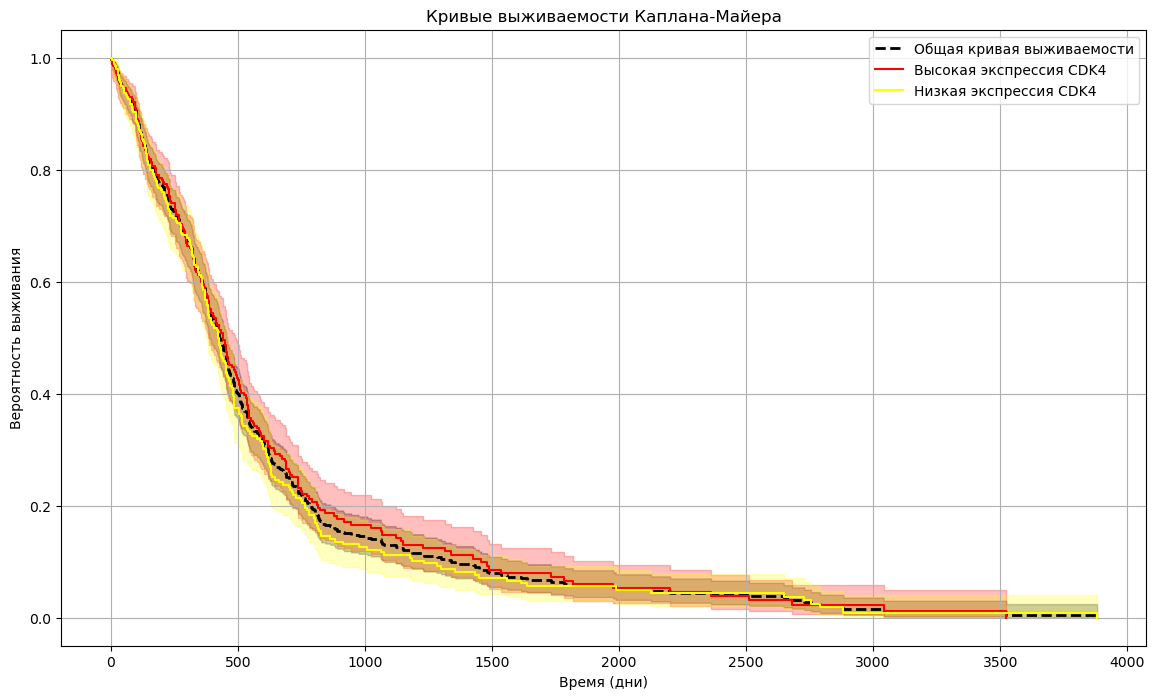

In [10]:
# Инициализация объекта KaplanMeierFitter
kmf = KaplanMeierFitter()

# Подгонка модели для общей кривой выживаемости
T = combined_data_filtered['OS.time']  # время выживания
E = combined_data_filtered['OS']       # событие (1 - событие наступило, 0 - цензура)

kmf.fit(T, event_observed=E, label='Общая кривая выживаемости')

# Построение общей кривой выживаемости
plt.figure(figsize=(14, 8))
ax = kmf.plot_survival_function(color='black', linestyle='--', linewidth=2)

# Построение кривых выживаемости для групп с высокой и низкой экспрессией TCDK4
gene = 'CDK4'
high_expression = combined_data_filtered[combined_data_filtered[gene] > combined_data_filtered[gene].median()]
low_expression = combined_data_filtered[combined_data_filtered[gene] <= combined_data_filtered[gene].median()]

kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

T_high = high_expression['OS.time']
E_high = high_expression['OS']

T_low = low_expression['OS.time']
E_low = low_expression['OS']

kmf_high.fit(T_high, event_observed=E_high, label=f'Высокая экспрессия {gene}')
kmf_low.fit(T_low, event_observed=E_low, label=f'Низкая экспрессия {gene}')

kmf_high.plot_survival_function(ax=ax, color='red', linestyle='-', linewidth=1.5)
kmf_low.plot_survival_function(ax=ax, color='yellow', linestyle='-', linewidth=1.5)

# Настройка графика
plt.title('Кривые выживаемости Каплана-Майера')
plt.xlabel('Время (дни)')
plt.ylabel('Вероятность выживания')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


# Выбор только необходимых столбцов для логистической регрессии
genes_of_interest = ['EGFR', 'PTEN', 'TP53', 'MDM2', 'CDK4']
X = combined_data_filtered[genes_of_interest]
y = combined_data_filtered['OS']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Инициализация и обучение модели логистической регрессии
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Прогнозирование на тестовых данных
y_pred = logreg.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

Accuracy: 0.8589743589743589
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.86      1.00      0.92       134

    accuracy                           0.86       156
   macro avg       0.43      0.50      0.46       156
weighted avg       0.74      0.86      0.79       156



/Users/elizaveta/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/elizaveta/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/elizaveta/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


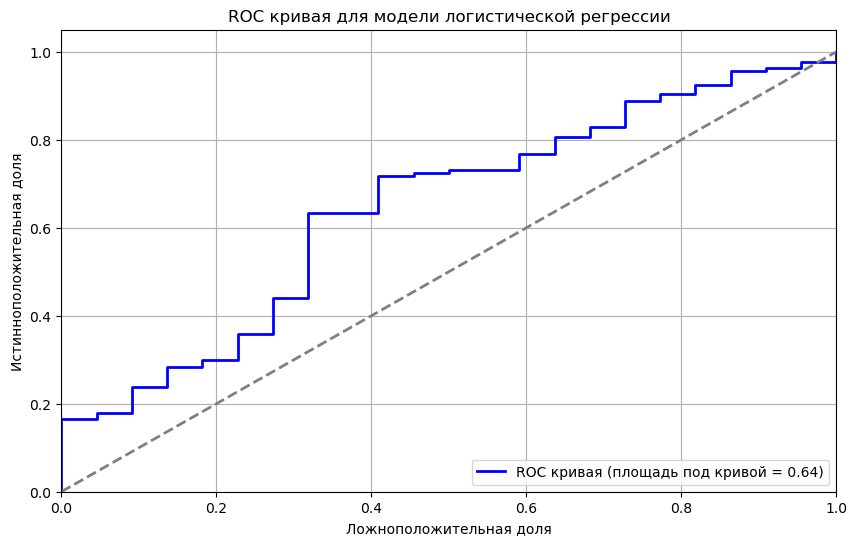

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_prob = logreg.predict_proba(X_test)[:, 1]

# Построение ROC кривой
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC кривая (площадь под кривой = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная доля')
plt.ylabel('Истинноположительная доля')
plt.title('ROC кривая для модели логистической регрессии')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Accuracy: 0.6528301886792452
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67       139
           1       0.63      0.64      0.64       126

    accuracy                           0.65       265
   macro avg       0.65      0.65      0.65       265
weighted avg       0.65      0.65      0.65       265



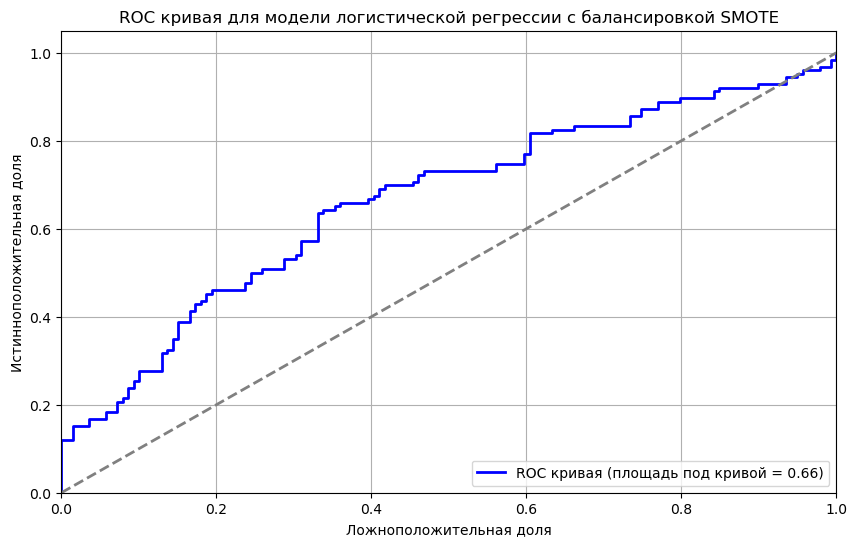

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Выбор только необходимых столбцов для логистической регрессии
genes_of_interest = ['EGFR', 'PTEN', 'TP53', 'MDM2', 'CDK4']
X = combined_data_filtered[genes_of_interest]
y = combined_data_filtered['OS']

# Балансировка классов с помощью 
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Инициализация и обучение модели логистической регрессии
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Прогнозирование вероятностей на тестовых данных
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

# Поиск оптимального порога
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Прогнозирование с использованием оптимального порога
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred_optimal)
classification_rep = classification_report(y_test, y_pred_optimal)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

# Построение ROC кривой
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC кривая (площадь под кривой = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная доля')
plt.ylabel('Истинноположительная доля')
plt.title('ROC кривая для модели логистической регрессии с балансировкой SMOTE')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Accuracy (ADASYN): 0.6259259259259259
Classification Report (ADASYN):
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       141
           1       0.64      0.50      0.56       129

    accuracy                           0.63       270
   macro avg       0.63      0.62      0.62       270
weighted avg       0.63      0.63      0.62       270



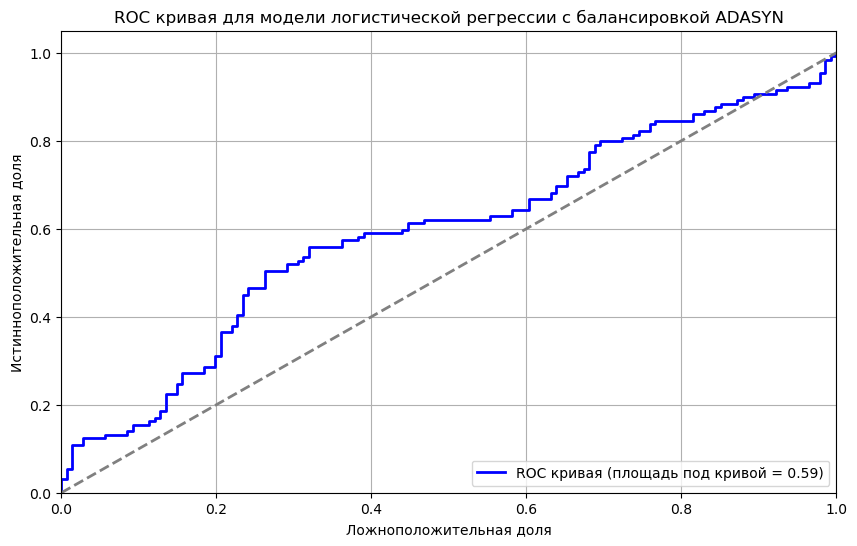

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt


# Выбор только необходимых столбцов для логистической регрессии
genes_of_interest = ['EGFR', 'PTEN', 'TP53', 'MDM2', 'CDK4']
X = combined_data_filtered[genes_of_interest]
y = combined_data_filtered['OS']

# Балансировка классов с помощью ADASYN
adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X, y)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Инициализация и обучение модели логистической регрессии
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Прогнозирование вероятностей на тестовых данных
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

# Поиск оптимального порога
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Прогнозирование с использованием оптимального порога
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred_optimal)
classification_rep = classification_report(y_test, y_pred_optimal)

print(f"Accuracy (ADASYN): {accuracy}")
print("Classification Report (ADASYN):")
print(classification_rep)


# Построение ROC кривой
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC кривая (площадь под кривой = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная доля')
plt.ylabel('Истинноположительная доля')
plt.title('ROC кривая для модели логистической регрессии с балансировкой ADASYN')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

/Users/elizaveta/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/elizaveta/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/elizaveta/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the f

Accuracy (Balanced Random Forest): 0.5705128205128205
Classification Report (Balanced Random Forest):
              precision    recall  f1-score   support

           0       0.22      0.82      0.35        22
           1       0.95      0.53      0.68       134

    accuracy                           0.57       156
   macro avg       0.58      0.67      0.51       156
weighted avg       0.84      0.57      0.63       156



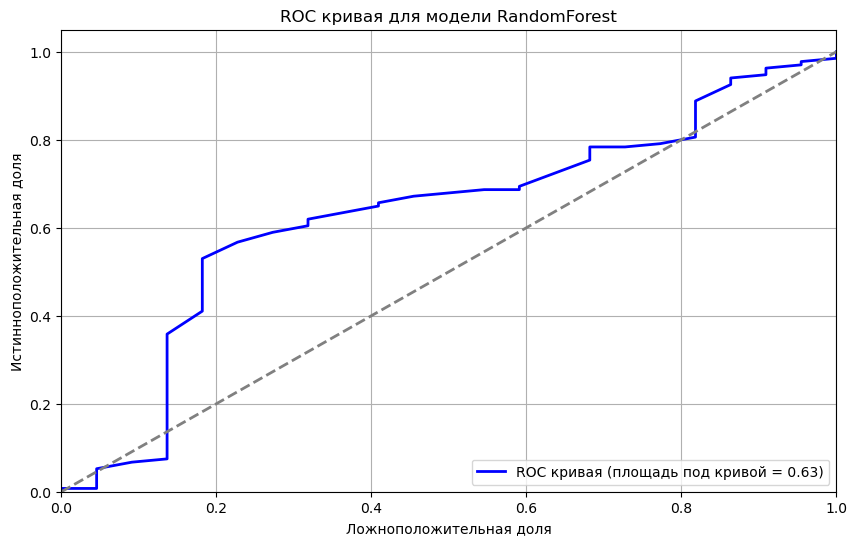

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt



# Выбор только необходимых столбцов для логистической регрессии
genes_of_interest = ['EGFR', 'PTEN', 'TP53', 'MDM2', 'CDK4']
X = combined_data_filtered[genes_of_interest]
y = combined_data_filtered['OS']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Инициализация и обучение модели Balanced Random Forest
balanced_rf = BalancedRandomForestClassifier(random_state=42)
balanced_rf.fit(X_train, y_train)

# Прогнозирование вероятностей на тестовых данных
y_pred_prob = balanced_rf.predict_proba(X_test)[:, 1]

# Поиск оптимального порога
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Прогнозирование с использованием оптимального порога
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred_optimal)
classification_rep = classification_report(y_test, y_pred_optimal)

print(f"Accuracy (Balanced Random Forest): {accuracy}")
print("Classification Report (Balanced Random Forest):")
print(classification_rep)

# Построение ROC кривой
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC кривая (площадь под кривой = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная доля')
plt.ylabel('Истинноположительная доля')
plt.title('ROC кривая для модели RandomForest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

/Users/elizaveta/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/elizaveta/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/elizaveta/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the f

Cross-validation scores: [0.625, 0.5288461538461539, 0.7884615384615384, 0.4077669902912621, 0.6699029126213593]
Average cross-validation score: 0.6039955190440627
Classification Report (Cross-Validated):
              precision    recall  f1-score   support

           0       0.21      0.62      0.32        77
           1       0.90      0.60      0.72       441

    accuracy                           0.60       518
   macro avg       0.56      0.61      0.52       518
weighted avg       0.80      0.60      0.66       518



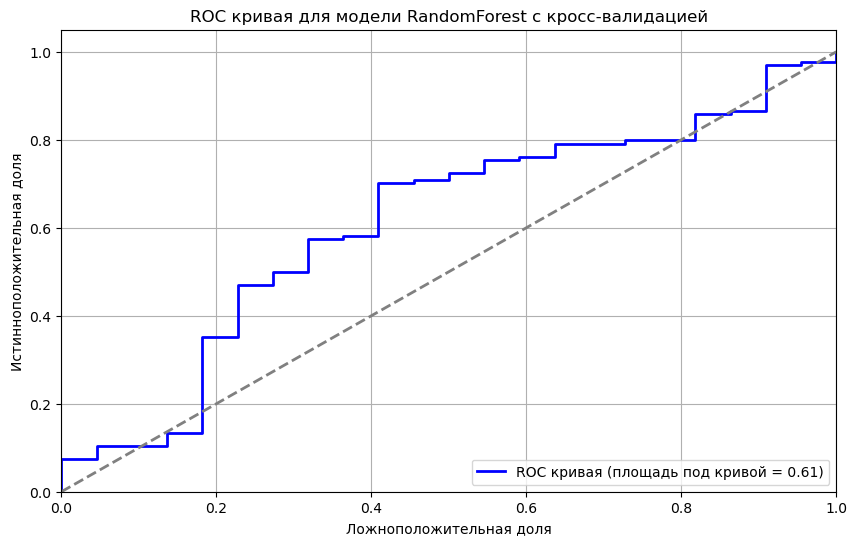

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer, classification_report, accuracy_score
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt



# Выбор только необходимых столбцов для логистической регрессии
genes_of_interest = ['EGFR', 'PTEN', 'TP53', 'MDM2', 'CDK4']
X = combined_data_filtered[genes_of_interest]
y = combined_data_filtered['OS']

# Инициализация модели Balanced Random Forest
balanced_rf = BalancedRandomForestClassifier(random_state=42)

# Настройка кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Функция для оценки модели и возвращения оптимального порога
def evaluate_model(model, X, y, cv):
    scores = []
    predictions = []
    true_labels = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Нахождение оптимального порога
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
        accuracy = accuracy_score(y_test, y_pred_optimal)
        scores.append(accuracy)
        predictions.extend(y_pred_optimal)
        true_labels.extend(y_test)
    return scores, predictions, true_labels

# Оценка модели с кросс-валидацией
scores, y_pred_all, y_true_all  = evaluate_model(balanced_rf, X, y, cv)


print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {np.mean(scores)}")
print("Classification Report (Cross-Validated):")
print(classification_report(y_true_all, y_pred_all))


# Построение ROC кривой
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC кривая (площадь под кривой = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная доля')
plt.ylabel('Истинноположительная доля')
plt.title('ROC кривая для модели RandomForest с кросс-валидацией')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Cross-validation scores: [0.6826923076923077, 0.5480769230769231, 0.8076923076923077, 0.3592233009708738, 0.49514563106796117]
Average cross-validation score: 0.5785660941000745
Classification Report (Gradient Boosting, Cross-Validated):
              precision    recall  f1-score   support

           0       0.21      0.68      0.32        77
           1       0.91      0.56      0.69       441

    accuracy                           0.58       518
   macro avg       0.56      0.62      0.51       518
weighted avg       0.80      0.58      0.64       518



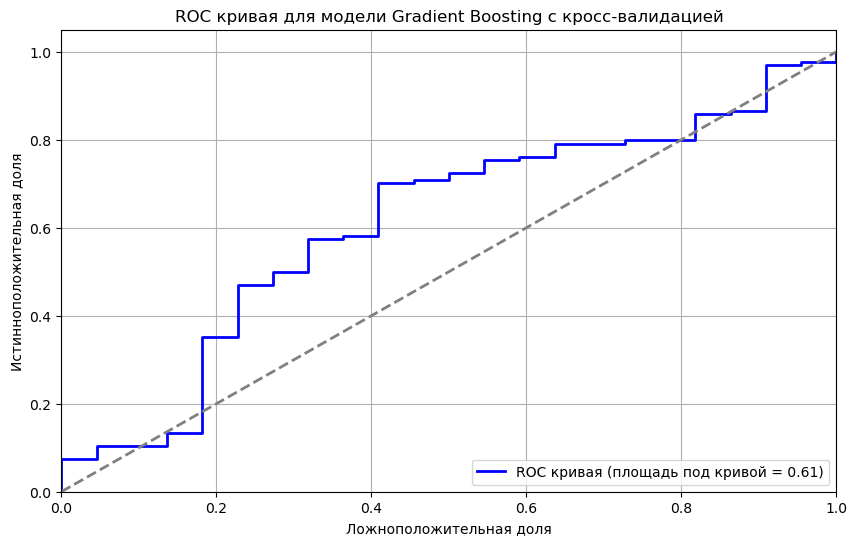

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt



# Выбор только необходимых столбцов для модели
genes_of_interest = ['EGFR', 'PTEN', 'TP53', 'MDM2', 'CDK4']
X = combined_data_filtered[genes_of_interest]
y = combined_data_filtered['OS']

# Инициализация модели Gradient Boosting
gradient_boosting = GradientBoostingClassifier(random_state=42)

# Настройка кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Функция для оценки модели и возвращения оптимального порога
def evaluate_model(model, X, y, cv):
    scores = []
    predictions = []
    true_labels = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_test)[:, 1]

         # Нахождение оптимального порога
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
        accuracy = accuracy_score(y_test, y_pred_optimal)
        scores.append(accuracy)
        predictions.extend(y_pred_optimal)
        true_labels.extend(y_test)
    return scores, predictions, true_labels

# Оценка модели с кросс-валидацией
scores, y_pred_all, y_true_all = evaluate_model(gradient_boosting, X, y, cv)

# Вывод результатов
print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {np.mean(scores)}")
print("Classification Report (Gradient Boosting, Cross-Validated):")
print(classification_report(y_true_all, y_pred_all))
      
      
      
# Построение ROC кривой
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC кривая (площадь под кривой = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная доля')
plt.ylabel('Истинноположительная доля')
plt.title('ROC кривая для модели Gradient Boosting с кросс-валидацией')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Accuracy (Gradient Boosting): 0.6858974358974359
Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.25      0.59      0.35        22
           1       0.91      0.70      0.79       134

    accuracy                           0.69       156
   macro avg       0.58      0.65      0.57       156
weighted avg       0.82      0.69      0.73       156



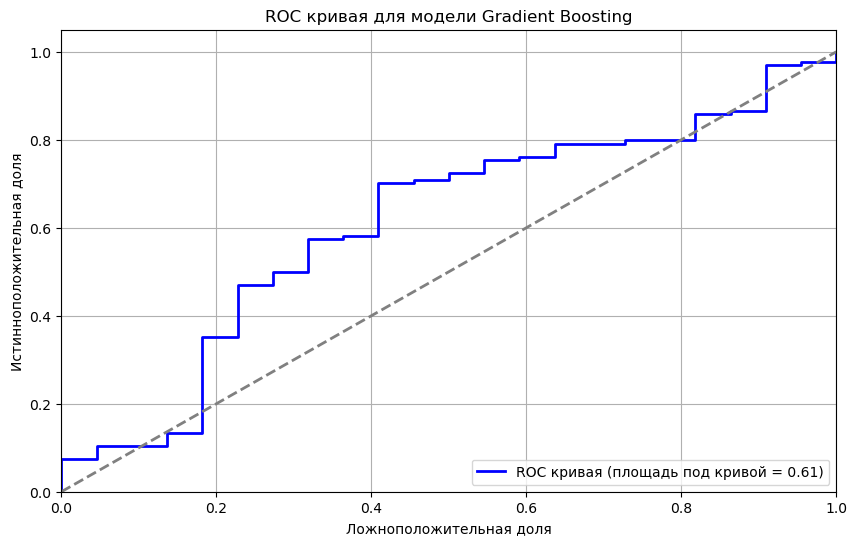

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt



# Выбор только необходимых столбцов для модели
genes_of_interest = ['EGFR', 'PTEN', 'TP53', 'MDM2', 'CDK4']
X = combined_data_filtered[genes_of_interest]
y = combined_data_filtered['OS']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Инициализация модели Gradient Boosting
gradient_boosting = GradientBoostingClassifier(random_state=42)

# Обучение модели
gradient_boosting.fit(X_train, y_train)

# Прогнозирование вероятностей на тестовых данных
y_pred_prob = gradient_boosting.predict_proba(X_test)[:, 1]

# Нахождение оптимального порога
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Прогнозирование с использованием оптимального порога
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred_optimal)
classification_rep = classification_report(y_test, y_pred_optimal)

# Вывод результатов
print(f"Accuracy (Gradient Boosting): {accuracy}")
print("Classification Report (Gradient Boosting):")
print(classification_rep)


# Построение ROC кривой
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC кривая (площадь под кривой = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительная доля')
plt.ylabel('Истинноположительная доля')
plt.title('ROC кривая для модели Gradient Boosting')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
